In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import sympy as sy
import scipy.linalg as la 
import scipy.sparse.linalg as spla
import time 
import matplotlib.pyplot as plt
import cmath
from utils import helper
sy.init_printing()
%matplotlib inline

### The GMRES Algorithm

Let $A$ be an invertible $m \times m$ matrix and let $b$ be an $m$-vector. Let $\mathcal{K}_n(A,b)$ be the order-$n$ Krylov subspace generated by $A$ and $b$. The idea of the GMRES algorithm is that instead of solving $Ax = b$ directly, we use least squares to find $x_n \epsilon \mathcal{K}_n$ that minimizes the residual $r_n = || b - Ax_n||_2$. The algorithm returns when this residual is sufficiently small. In good circumstances, this will happen when $n$ is still much less than $m$.

The GMRES algorithm is implemented with the Arnoldi iteration for numerical stability. The Arnoldi iteration produces $H_n$, an $(n + 1) \times n$ upper Hessenberg matrix, and $Q_n$, the matrix containing the basis vectors of $K_n(A,b)$, such that $AQn = Q_{n+1}H_n$. We are looking for $x_n = Q_ny_n + x_0$ for some $y_n \epsilon \mathbb{R}^n$ which minimizes the norm of $b - Ax_n$. Since the columns of $Q$ are orthonormal, we can compute the residual equivalently as

$$|| b-Ax_n||_2 = ||Q_{n+1}(\beta e_1 - H_ny_n)||_2 = ||H_ny_n - \beta e_1||_2$$

Here $e_1$ is the vector (1,0,...,0) of length $n + 1$. $\beta$ is the Euclidean norm of $b - Ax_0$, where x_0 is an initial arbitrary guess of the solution. (Ordinarily this guess is zero, and then the $Ax_0$ could be left out; however, a modified version of the algorithm will be discussed at the end of the lab, in which other nonzero guesses will be made.) Thus to minimize the left side of 17.1, we can minimize the right, and $x_n$ can be computed as $Q_ny_n + x_0$.

### Problem 1.
Use Algorithm 17.1 to complete the following Python function implementing the GMRES algorithm.

        def gmres(A, b, x0, k=100, tol=1e-8):
            '''Calculate approximate solution of Ax=b using GMRES algorithm.
            INPUTS:
                ￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼ 
            A   - Callable function that calculates Ax for any input vector x.
            b   - A NumPy array of length m.
            x0  - An arbitrary initial guess.
            k   - Maximum number of iterations of the GMRES algorithm. Defaults -
                ￼￼￼￼￼￼￼￼to 100.
            tol - Stop iterating if the residual is less than 'tol'. Defaults to -
                1e-8.
            RETURN:
                Return (y, res) where 'y' is an approximate solution to Ax=b and 'res' is the residual.
            Examples:
            >>> a = np.array([[1,0,0],[0,2,0],[0,0,3]]) >>> A = lambda x: a.dot(x)
            >>> b = np.array([1, 4, 6])
            >>> x0 = np.zeros(b.size)
            >>> gmres(A, b, x0)
            (array([ 1., 2., 2.]), 1.09808907533e-16) '''
            
You may assume that the input b is a real array and the function A() always outputs real arrays.

Hint: Use numpy.linalg.lstsq() to solve the least squares problem. Be sure to read the documentation so you know what the function returns to you.

In [41]:
def gmres(A, b, x0, k=100, tol=1e-8):
    '''Calculate approximate solution of Ax=b using GMRES algorithm.
        INPUTS:
            ￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼ 
        A   - Callable function that calculates Ax for any input vector x.
        b   - A NumPy array of length m.
        x0  - An arbitrary initial guess.
        k   - Maximum number of iterations of the GMRES algorithm. Defaults -
            ￼￼￼￼￼￼￼￼to 100.
        tol - Stop iterating if the residual is less than 'tol'. Defaults to -
            1e-8.
        RETURN:
            Return (y, res) where 'y' is an approximate solution to Ax=b and 'res' is the residual.
        Examples:
        >>> a = np.array([[1,0,0],[0,2,0],[0,0,3]]) >>> A = lambda x: a.dot(x)
        >>> b = np.array([1, 4, 6])
        >>> x0 = np.zeros(b.size)
        >>> gmres(A, b, x0)
        (array([ 1., 2., 2.]), 1.09808907533e-16) 
    '''
    Q = np.zeros((len(b), k+1))
    H = np.zeros((k+1, k))
    r0 = b - A(x0)
    Q[:,0] = r0/np.linalg.norm(r0)
    
    e1 = np.zeros(k+1)
    e1[0] = 1

    residuals = []
    for j in range(k):
        Q[:, j+1] = A(Q[:,j])
        for i in range(j+1):
            H[i,j] = np.dot(Q[:,i].T, Q[:,j+1])
            Q[:,j+1] = Q[:,j+1] - H[i,j]*Q[:,i]
        H[j+1,j] = np.linalg.norm(Q[:,j+1])
        if np.abs(H[j+1,j])!=0:
            Q[:,j+1] = Q[:,j+1]/H[j+1,j]  
        
        beta = np.linalg.norm(r0)
        yn= np.linalg.lstsq(H, beta*e1)[0]
        res = np.linalg.norm(np.dot(H, yn) - beta*e1)
        residuals.append(res)
        if res<tol: 
            break
        
        
    return np.dot(Q[:,:-1],yn)+x0, residuals, j
        

In [42]:
k = 100
dim = 20
A = np.random.random((dim,dim))
Amul = lambda x: np.dot(A,x)
b = np.random.random(dim)
x0 = np.zeros(dim)


xn,res,n_iter = gmres(Amul, b, x0)
xn,res,n_iter

(array([ 1.11841059,  1.43023953, -0.1611026 ,  1.19006334, -0.55660652,
        -1.38146536,  0.33970957,  0.38045333, -1.67323821,  1.64770341,
         0.72581261,  1.57916687,  1.21104917, -1.88981205, -1.54376337,
        -1.02816758,  1.52904968,  0.15952693, -0.63694915, -0.55722757]),
 [1.1016761844772573,
  1.0718761237243886,
  1.0654905366475218,
  1.0551338352878394,
  1.0531820181162515,
  0.99296483970713556,
  0.89876340526806608,
  0.87645816699787038,
  0.86164369877461111,
  0.82004769510115805,
  0.6637091950391264,
  0.66172524510755371,
  0.47655059024352103,
  0.46562236156126469,
  0.46502026445724165,
  0.40889164281121376,
  0.40157629110264575,
  0.057345117892453383,
  0.0010452165270709716,
  4.9011976535343253e-15],
 19)

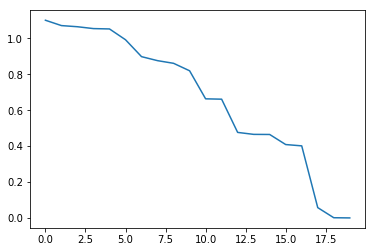

In [43]:
plt.plot(res)

In [44]:
#test
b_ = np.dot(A,xn)
b_

array([ 0.38816699,  0.66278546,  0.55675461,  0.48267584,  0.43205047,
        0.76603323,  0.52061334,  0.10190561,  0.39463211,  0.51436792,
        0.73186785,  0.52294836,  0.63112075,  0.88523788,  0.18034696,
        0.81595139,  0.41277024,  0.23516284,  0.43004075,  0.04594311])

In [45]:
b

array([ 0.38816699,  0.66278546,  0.55675461,  0.48267584,  0.43205047,
        0.76603323,  0.52061334,  0.10190561,  0.39463211,  0.51436792,
        0.73186785,  0.52294836,  0.63112075,  0.88523788,  0.18034696,
        0.81595139,  0.41277024,  0.23516284,  0.43004075,  0.04594311])

In [46]:
np.allclose(b,b_)

True

### Problem 2. 

Implement the following Python function by modifying your solution to Problem 1.
￼￼


        def plot_gmres(A, b, x0, tol=1e-8):
            '''Use the GMRES algorithm to approximate the solution to Ax=b. Plot -
                 the eigenvalues of A and the convergence of the algorithm.
            INPUTS:
            A   - A 2-D NumPy array of shape mxm.
            b   - A 1-D NumPy array of length m.
            x0  - An arbitrary initial guess.
            tol - Stop iterating and create the desired plots when the residual is 
                less than 'tol'. Defaults to 1e-8.
            OUTPUT:
            Follow the GMRES algorithm until the residual is less than tol, for a
            maximum of m iterations. Then create the two following plots (subplots
            of a single figure):
            1. Plot the eigenvalues of A in the complex plane.
            2. Plot the convergence of the GMRES algorithm by plotting the iteration number on the x-axis and the 
            residual on the y-axis. Use a log scale on the y-axis.
            '''
            
Use this function to investigate the convergence of GMRES as follows.
Define an $m x m$ matrix

$$A_n = nI + P,$$

where $I$ is the $m \times m$ identity matrix and $P$ is a $m \times m$ matrix of numbers from a random normal distribution with mean 0 and standard deviation $1/(2\sqrt{m})$. Write a function that calls `plot_gmres` on $A_n$ for $n = -4, -2, 0, 2, 4$. Use $m = 200$, let `b` be an array of ones, and let `x0` be the zero vector or anything else that suits you. How does the convergence of the GMRES algorithm relate to the eigenvalues?

Hints:

1. Create a plot with a log scale on the y-axis with `plt.yscale('log')`.
2. Create a matrix with entries from a random normal distribution with `np.random.normal()`. Read the documentation for more information.
3. Note that the parameter $A$ required here is not a callable function but a matrix; this is to allow the finding eigenvalues.
4. Output for $n=2, m=200$ is in Figure 17.1 below.

Ideas for this problem were taken from Example 35.1 on p.271 of $[\textbf{Trefethen}]$

In [47]:
def plot_gmres(A, b, x0, tol=1e-8):
    '''Use the GMRES algorithm to approximate the solution to Ax=b. Plot -
         the eigenvalues of A and the convergence of the algorithm.
    INPUTS:
    A   - A 2-D NumPy array of shape mxm.
    b   - A 1-D NumPy array of length m.
    x0  - An arbitrary initial guess.
    tol - Stop iterating and create the desired plots when the residual is 
        less than 'tol'. Defaults to 1e-8.
    OUTPUT:
    Follow the GMRES algorithm until the residual is less than tol, for a
    maximum of m iterations. Then create the two following plots (subplots
    of a single figure):
    1. Plot the eigenvalues of A in the complex plane.
    2. Plot the convergence of the GMRES algorithm by plotting the iteration number on the x-axis and the 
    residual on the y-axis. Use a log scale on the y-axis.
    '''
    eigs = la.eig(A)[0]
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(eigs.real, eigs.imag, 'bo', ms = 2)
    
    Amul = lambda x: np.dot(A,x)
    xn,residuals, n_iter = gmres(Amul, b, x0, k=len(A))
    plt.subplot(132)
    plt.plot(np.arange(n_iter+1), residuals)
    
    plt.subplot(133)
    plt.plot(np.arange(n_iter+1), residuals)
    plt.yscale('log')

In [50]:
m = 2000
ns = np.array([-4, -2, 0, 2, 4])
sd = (2*np.sqrt(m))**-1
As = np.stack([i*np.eye(m) for i in ns]) + np.random.normal(scale = sd, size=(len(ns), m,m))
print("A shape:", As.shape)

x0 = np.zeros(m)
b = np.ones(m)

A shape: (5, 2000, 2000)


In [ ]:
for A in As:
    plot_gmres(A, b, x0)

### Problem 3. 
Implement Algorithm 17.2 with the following function.

    def gmres_k(A, b, x0, k=5, tol=1E-8, restarts=50):
    '''Use the GMRES(k) algorithm to approximate the solution to Ax=b.
        INPUTS:
        A        - A callable function that calculates Ax for any vector x.
        b        - A NumPy array.
        x0       - An arbitrary initial guess.
        k        - Maximum number of iterations of the GMRES algorithm before
    restarting. Defaults to 5.
    tol - Stop iterating if the residual is less than 'tol'. Defaults
                  to 1E-8.
        restarts - Maximum number of restarts. Defaults to 50.
    RETURN:
    Return (y, res) where 'y' is an approximate solution to Ax=b and 'res' is the residual.
    '''
 Compare the speed of gmres() from Problem 1 and gmres_k() on the matrices on Problem 2.

In [10]:
def gmres_k(A, b, x0, k=100, tol=1e-8, restarts=50):
    '''
    Use the GMRES(k) algorithm to approximate the solution to Ax=b.
        INPUTS:
        A        - A callable function that calculates Ax for any vector x.
        b        - A NumPy array.
        x0       - An arbitrary initial guess.
        k        - Maximum number of iterations of the GMRES algorithm before
    restarting. Defaults to 5.
    tol - Stop iterating if the residual is less than 'tol'. Defaults
                  to 1E-8.
        restarts - Maximum number of restarts. Defaults to 50.
    RETURN:
    Return (y, res) where 'y' is an approximate solution to Ax=b and 'res' is the residual.
    '''
    Q = np.zeros((len(b), k+1))
    H = np.zeros((k+1, k))
    r0 = b - A(x0)
    Q[:,0] = r0/np.linalg.norm(r0)

    e1 = np.zeros(k+1)
    e1[0] = 1

    residuals = []
    n = 0
    while n <= restarts:
        for j in range(k):
            Q[:, j+1] = A(Q[:,j])
            for i in range(j+1):
                H[i,j] = np.dot(Q[:,i].T, Q[:,j+1])
                Q[:,j+1] = Q[:,j+1] - H[i,j]*Q[:,i]
            H[j+1,j] = np.linalg.norm(Q[:,j+1])
            if np.abs(H[j+1,j])!=0:
                Q[:,j+1] = Q[:,j+1]/H[j+1,j]  

            beta = np.linalg.norm(r0)
            yn= np.linalg.lstsq(H, beta*e1)[0]
            res = np.linalg.norm(np.dot(H, yn) - beta*e1)
            residuals.append(res)
            if res<tol: 
                break
        x0 = yn
        n = n+1
    return np.dot(Q[:,:-1],yn), residuals

In [11]:
dim = 20
A = np.random.random((dim, dim))
b = np.random.random(dim)
x0 = np.zeros(dim)

Amul = lambda x: np.dot(A,x)

k = 100
tol=1e-8, 
restarts=50

In [12]:
xn, residuals = gmres_k(Amul, b, x0, k=k, tol=tol, restarts=restarts)

In [13]:
#let's check
b_ = np.dot(A, xn)
b_

array([ 0.14325193,  0.5189836 ,  0.51769848,  0.04718159,  0.01820421,
        0.25887027,  0.29299738,  0.65948184,  0.66000916,  0.7451779 ,
        0.79444569,  0.4127351 ,  0.45762484,  0.25379221,  0.70150311,
        0.51642584,  0.76944907,  0.12736212,  0.84600442,  0.92724374])

In [14]:
b

array([ 0.14325193,  0.5189836 ,  0.51769848,  0.04718159,  0.01820421,
        0.25887027,  0.29299738,  0.65948184,  0.66000916,  0.7451779 ,
        0.79444569,  0.4127351 ,  0.45762484,  0.25379221,  0.70150311,
        0.51642584,  0.76944907,  0.12736212,  0.84600442,  0.92724374])

In [15]:
np.allclose(b, b_)

True

In [23]:
#time the gmres and gmres_k on matrices in Problem 2
m = 200
ns = np.array([-4, -2, 0, 2, 4])
sd = (2*np.sqrt(m))**-1
As = np.stack([i*np.eye(m) for i in ns]) + np.random.normal(scale = sd, size=(len(ns), m,m))
print("A shape:", As.shape)

x0 = np.zeros(m)
b = np.ones(m)

A shape: (5, 200, 200)


In [26]:
time_diff = []
for A in As:
    Amul = lambda x: np.dot(A,x)
    
    start_gmresk = time.time()
    xn,res = gmres_k(Amul, b, x0, k=200)
    end_gmresk = time.time()
    
    start_gmres = time.time()
    xn, res, j = gmres(Amul, b, x0, k=200)
    end_gmres = time.time()
    
    time_diff.append([end_gmres-start_gmres, 
                      end_gmresk-start_gmresk])

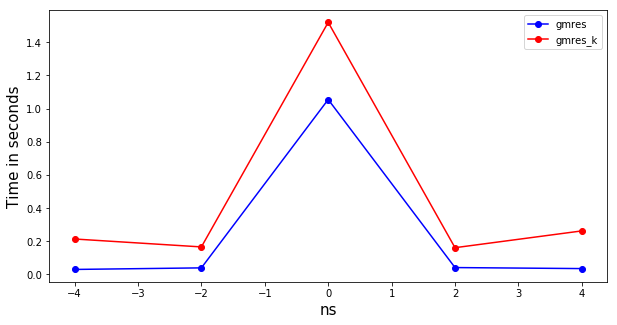

In [27]:
time_diff = np.array(time_diff)

plt.figure(figsize=(10,5))
plt.plot(ns, time_diff[:,0], 'bo-', label = "gmres")
plt.plot(ns, time_diff[:,1], 'ro-', label = "gmres_k")
plt.xlabel("ns", size = 15)
plt.ylabel("Time in seconds", size = 15)
plt.legend()

### GMRES in Scipy 

In [33]:
from scipy import sparse as spar
from scipy import linalg as la

A = np.random.rand(300, 300)
b = np.random.rand(300)
#gmres
x, info = spar.linalg.gmres(A, b)
info

In [37]:
la.norm(A.dot(x)-b)

In [39]:
#gmres with restarts
x, info = spar.linalg.gmres(A, b, restart=1000)
info

In [40]:
la.norm(A.dot(x)-b)